### 載入所需的Libraries

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from typing import List

### 載入資料

In [2]:
# read data from spam.csv
sms_data = pd.read_csv('spam.csv', header=0, encoding='cp1252')
sms_data = sms_data.loc[:, ['v1', 'v2']]
sms_data.columns = ['label', 'content']
sms_data.head()

,label,content
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
# check how many spams and hams                # 可以用 groupby
spam_count = sms_data['label'].value_counts().reset_index()
spam_count.columns = ['label', 'content']
spam_count.set_index('label', inplace = True)
spam_count

,content
label,
ham,4825
spam,747


In [4]:
# change label to from string to number
# "ham" --> 0, "spam" --> 1
label_map = {'ham':0, 'spam':1}
sms_data['label'] = sms_data['label'].map(label_map)
sms_data.head()

,label,content
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


### 切分資料
將資料依據label比例切分為training data與testing data

In [5]:
X_train, X_test, y_train, y_test = train_test_split(sms_data['content'], sms_data['label'], test_size=0.2, stratify=sms_data['label'])
#X_train.shape, y_train.shape, X_test.shape, y_test.shape

sms_train = pd.DataFrame({'label':y_train, 'content':X_train})
sms_test = pd.DataFrame({'label':y_test, 'content':X_test})

print(sms_train.groupby("label").count())
print(sms_test.groupby("label").count())

       content
label         
0         3859
1          598
       content
label         
0          966
1          149


In [6]:
sms_train.reset_index(drop=True, inplace=True)
sms_test.reset_index(drop=True, inplace=True)

In [7]:
sms_train.head()

,label,content
0,1,Free Msg: Ringtone!From: http://tms. widelive....
1,0,Your gonna be the death if me. I'm gonna leave...
2,0,Not tonight mate. Catching up on some sleep. T...
3,0,"No, I decided that only people who care about ..."
4,0,"I am real, baby! I want to bring out your inne..."


### 資料預處理
* 將所有字詞轉為小寫
* 移除所有數字、標點符號

In [8]:
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    
    for i in range(len(df)):
        # make all content to lowercase
        content = df.iloc[i, 1].lower()

        # remove all punctuations
        words = re.findall(r'[\w]+', content)
        df.iloc[i, 1] = ' '.join(words)
    
    return df

processed_train = preprocess(sms_train)
processed_test = preprocess(sms_test)

print("Train:")
print(processed_train.head())
print("Test:")
print(processed_test.head())

Train:
   label                                            content
0      1  free msg ringtone from http tms widelive com i...
1      0  your gonna be the death if me i m gonna leave ...
2      0  not tonight mate catching up on some sleep thi...
3      0  no i decided that only people who care about s...
4      0  i am real baby i want to bring out your inner ...
Test:
   label                                            content
0      0  ya i knw u vl giv its ok thanks kano anyway en...
1      0  as per your request melle melle oru minnaminun...
2      0  watching cartoon listening music amp at eve ha...
3      0          great so what attracts you to the brothas
4      0  yes i have so that s why u texted pshew missin...


In [6]:
# def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    
#     for i in range(len(df)):
#         # make all content to lowercase
#         content = df.iloc[i, 'content'].lower()

#         # remove all punctuations
#         words = re.findall(r'[^\W_]+', content)
#         df.iloc[i, 'content'] = ' '.join(words)
    
#     return df

# processed_train = preprocess(sms_train)
# processed_test = preprocess(sms_test)

# print("Train:")
# print(processed_train.head())
# print("Test:")
# print(processed_test.head())

/Users/admin/Documents/cupoy/cupoy_env/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/admin/Documents/cupoy/cupoy_env/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Train:
  label                                            content
0     0  mmmmm it was sooooo good to wake to your words...
1     0                    how much did ur hdd casing cost
2     0  total disappointment when i texted you was the...
3     0  wen ur lovable bcums angry wid u dnt take it s...
4     0                    i will spoil you in bed as well
Test:
  label                                            content
0     0  i sent you the prices and do you mean the lt gt g
1     0   havent still waitin as usual come back sch oredi
2     0               why tired what special there you had
3     0  my painful personal thought i always try to ke...
4     0                            hurry home soup is done


In [9]:
# split data into x_train, y_train, x_test, y_test
y_train, x_train = zip(*processed_train.values)
y_test, x_test = zip(*processed_test.values)

# check numbers of unique word in the corpus
uniqueWords = set(" ".join(list(x_train + x_test)).split())
len(uniqueWords)

8713

In [7]:
# # split data into x_train, y_train, x_test, y_test
# y_train, x_train = zip(*processed_train.values)
# y_test, x_test = zip(*processed_test.values)

# # check numbers of unique word in the corpus
# len(set(" ".join(list(x_train + x_test)).split()))

7708

### TF-IDF
可以發現種共有7708個字詞，這裡使用TF-IDF將來選取最高分的前2000個字詞
(若忘記的學員可參考先前TF-IDF課程章節或[此篇教學](https://ithelp.ithome.com.tw/articles/10228815?sc=iThelpR))

In [10]:
vectorizer = TfidfVectorizer(max_features=2000, smooth_idf=True)
tfidf = vectorizer.fit_transform(list(x_train+x_test))

tfidf_train = tfidf[:4457, :]
tfidf_test = tfidf[4457:, :]

print(f"Number of unique word: {len(vectorizer.vocabulary_)}")
(tfidf_train, tfidf_test)

Number of unique word: 2000


(<4457x2000 sparse matrix of type '<class 'numpy.float64'>'
 	with 50899 stored elements in Compressed Sparse Row format>,
 <1115x2000 sparse matrix of type '<class 'numpy.float64'>'
 	with 13105 stored elements in Compressed Sparse Row format>)

### 建立共現矩陣

In [11]:
def create_co_matrix(corpus: List[str], vocab_list: List[str], word2idx: dict,
                     window_size: int=1, use_weighting: bool=False, verbose: bool=False) -> np.ndarray:
    '''Function to create co-occurrence matrix
    '''
    #initialize co-occurrence matrix
    co_matrix = np.zeros(shape=(len(word2idx), len(word2idx)), dtype=np.int32)
    
    for idx, sms in enumerate(corpus):
        sms_list = sms.split(' ')
        sms_ids = list()
        
        for w in sms_list:
            if w in word2idx:                                 # 將每一筆資料轉成 word index
                sms_ids.append(word2idx[w])                   # 若不在 word index 裡的字都轉成 -1
            else:
                sms_ids.append(-1)
        
        for center_i, center_word_id in enumerate(sms_ids):
            if center_word_id != -1:
                left_center_i = center_i - window_size if center_i-window_size >= 0 else 0
                context_ids = sms_ids[left_center_i:center_i]

                for left_i, left_word_id in enumerate(context_ids):
                    if left_word_id != -1:
                        co_matrix[center_word_id, left_word_id] += 1
                        co_matrix[left_word_id, center_word_id] += 1
        
        if verbose:
            if idx != 0 and idx%500 == 0:
                    print(f"finishing {idx+1}/{len(corpus)}")
    print("Done")
    if use_weighting:
        # if use weighting, then we set the co-occurrence with the word itself to 1.0
        for i in range(len(word2idx)):
            co_matrix[i, i] = 1
        
    return co_matrix

co_matrix = create_co_matrix(x_train, vectorizer.get_feature_names(), vectorizer.vocabulary_,
                            window_size=3, use_weighting=True, verbose=True)

co_matrix

finishing 501/4457
finishing 1001/4457
finishing 1501/4457
finishing 2001/4457
finishing 2501/4457
finishing 3001/4457
finishing 3501/4457
finishing 4001/4457
Done


array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]])

### 建立PPMI矩陣

$$
\begin{aligned}
&PMI(x,y) = log_2\frac{P(x,y)}{P(x)P(y)} = log_2\frac{C(x,y)N}{C(x)C(y)} \\
&PPMI(x,y) = max(0,PMI(x,y))
\end{aligned}
$$

In [12]:
#定義正向點間互資訊

def ppmi(co_matrix: np.ndarray, eps: float=1e-8, verbose: bool=False):
    M = np.zeros_like(co_matrix, dtype=np.float32)
    N = np.sum(co_matrix)
    S = np.sum(co_matrix, axis=0)
    total = co_matrix.shape[0]*co_matrix.shape[1]
    
    cnt = 0
    
    for i in range(co_matrix.shape[0]):
        for j in range(co_matrix.shape[1]):
            pmi = np.log2(co_matrix[i, j]*N / (S[i]*S[j]+eps))
            M[i, j] = max(0, pmi)
            
            if verbose:
                cnt += 1
                if cnt % 10 == 0 or cnt == total:
                    print(f"{cnt}/{total} Done")
    
    return M

ppmi_matrix = ppmi(co_matrix, verbose=False)
ppmi_matrix

C:\Users\brian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log2
  del sys.path[0]


array([[8.647933 , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 4.9653287, 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 8.416979 , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 3.3030825, 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 6.9653287,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        9.817858 ]], dtype=float32)

In [10]:
# #定義正向點間互資訊

# def ppmi(co_matrix: np.ndarray, eps: float=1e-8, verbose: bool=False):
#     M = np.zeros_like(co_matrix, dtype=np.float32)
#     N = np.sum(co_matrix)
#     S = np.sum(co_matrix, axis=0)
#     total = co_matrix.shape[0]*co_matrix.shape[1]
    
#     cnt = 0
    
#     for i in range(co_matrix.shape[0]):
#         for j in range(co_matrix.shape[1]):
#             pmi = np.log2(co_matrix[i, j]*N / (S[i]*S[j]+eps))
#             M[i, j] = max(0, pmi)
            
#             if verbose:
#                 cnt += 1
#                 if cnt % 10 == 0 or cnt == total:
#                     print(f"{cnt}/{total} Done")
    
#     return M

# ppmi_matrix = ppmi(co_matrix, verbose=False)
# ppmi_matrix

/Users/admin/Documents/cupoy/cupoy_env/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log2
  del sys.path[0]


array([[13.601798 ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       , 12.637939 ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  3.8175101, ...,  0.       ,  0.       ,
         0.       ],
       ...,
       [ 0.       ,  0.       ,  0.       , ...,  9.8432665,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  4.743008 ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         6.7493014]], dtype=float32)

### 使用SVD降維
利用sklearn中的TruncatedSVD對co-occurrence matrix進行降維，並利用variance來找出最適合的維度
[參考文獻](https://medium.com/swlh/truncated-singular-value-decomposition-svd-using-amazon-food-reviews-891d97af5d8d)

(讀者可以嘗試使用SVD對PPMI進行降維)

Number of components = 10 and explained variance = 0.8112497600539001
Number of components = 20 and explained variance = 0.8614855670176047
Number of components = 30 and explained variance = 0.8873812573092192
Number of components = 40 and explained variance = 0.9042166121509145
Number of components = 50 and explained variance = 0.91710847518452
Number of components = 60 and explained variance = 0.9271401488208432
Number of components = 70 and explained variance = 0.9352414902706506
Number of components = 80 and explained variance = 0.9419707604000174
Number of components = 90 and explained variance = 0.9475341634221285
Number of components = 100 and explained variance = 0.9522891512072504
Number of components = 110 and explained variance = 0.9562775626380058
Number of components = 120 and explained variance = 0.9598011829648532
Number of components = 130 and explained variance = 0.9627501976278172
Number of components = 140 and explained variance = 0.9653429168647858
Number of compone

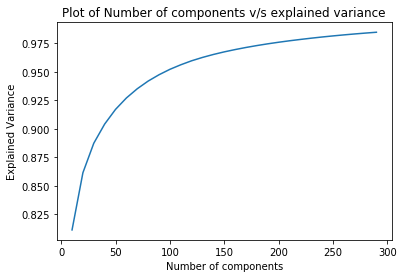

In [16]:
# Program to find the optimal number of components for Truncated SVD
n_comp = range(10,300,10) # list containing different values of components
variance_sum = [] # explained variance ratio for each component of Truncated SVD

for dim in n_comp:
    svd = TruncatedSVD(n_components=dim)
    svd.fit(co_matrix)
    variance_sum.append(svd.explained_variance_ratio_.sum())
    print(f'Number of components = {dim} and explained variance = {variance_sum[-1]}')
    
plt.plot(n_comp, variance_sum)
plt.xlabel('Number of components')
plt.ylabel("Explained Variance")
plt.title("Plot of Number of components v/s explained variance")
plt.show()

Number of components = 10 and explained variance = 0.8642725587999802
Number of components = 20 and explained variance = 0.8980414674614533
Number of components = 30 and explained variance = 0.9156628006889777
Number of components = 40 and explained variance = 0.927689024601538
Number of components = 50 and explained variance = 0.936793376016642
Number of components = 60 and explained variance = 0.9440622100583419
Number of components = 70 and explained variance = 0.9497335259111686
Number of components = 80 and explained variance = 0.9545927350412019
Number of components = 90 and explained variance = 0.9586825009775746
Number of components = 100 and explained variance = 0.9622576661554756
Number of components = 110 and explained variance = 0.9653164683546815
Number of components = 120 and explained variance = 0.9680388058100005
Number of components = 130 and explained variance = 0.9704123451115438
Number of components = 140 and explained variance = 0.9725534055673797


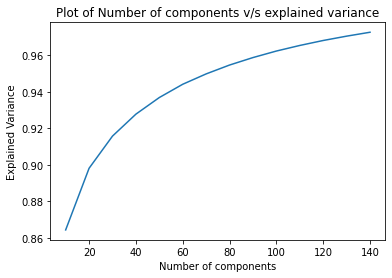

In [11]:
# # Program to find the optimal number of components for Truncated SVD
# n_comp = range(10,150,10) # list containing different values of components
# variance_sum = [] # explained variance ratio for each component of Truncated SVD

# for dim in n_comp:
#     ## your code
    
# plt.plot(n_comp, variance_sum)
# plt.xlabel('Number of components')
# plt.ylabel("Explained Variance")
# plt.title("Plot of Number of components v/s explained variance")
# plt.show()

In [17]:
# 利用上述找到的最適合dimension來對co-occurrence matrix進行降維
# dimension = 200

svd = TruncatedSVD(n_components=200)
co_matrix_transformed = svd.fit_transform(co_matrix)

co_matrix_transformed.shape

(2000, 200)

### 使用KNN模型進行分類
在進行分類之前，先利用簡單的詞向量平均來計算文本向量

[參考文獻](https://medium.com/ai-academy-taiwan/nlp-%E4%B8%8D%E5%90%8C%E8%A9%9E%E5%90%91%E9%87%8F%E5%9C%A8%E6%96%87%E6%9C%AC%E5%88%86%E9%A1%9E%E4%B8%8A%E7%9A%84%E8%A1%A8%E7%8F%BE%E8%88%87%E5%AF%A6%E4%BD%9C-e72a2daecfc)

In [18]:
# get doc vector via take mean of all word vectors inside the corresponding document

def make_doc_vectors(corpus: List[str], word2idx: dict, vocab_list: List) -> List[np.ndarray]:
    
    # vectorizing data 
    # and make document vector by take mean to all word vecto
    doc_vec = []
    empty_doc_list = []
    for i, sms_msg in enumerate(corpus):
        sms_msg = [word2idx[word] for word in sms_msg.split() if word in vocab_list] #tokenize
        if len(sms_msg) > 0:
            sms_msg = np.array([co_matrix_transformed[ids] for ids in sms_msg]) #vectorize
            doc_vec.append(sms_msg.mean(axis=0))
        else:
            empty_doc_list.append(i)
            print(f"document {i} doesn't contain word in vocab_list")
            print(corpus[i])
            print("\n")
        
    return np.vstack(doc_vec), empty_doc_list

word2idx = vectorizer.vocabulary_
vocab_list = vectorizer.get_feature_names()

doc_vec_train, missing_train_list = make_doc_vectors(x_train, word2idx, vocab_list)
print("="*50)
doc_vec_test, missing_test_list = make_doc_vectors(x_test, word2idx, vocab_list)

document 812 doesn't contain word in vocab_list



document 1043 doesn't contain word in vocab_list
raviyog peripherals bhayandar east


document 1061 doesn't contain word in vocab_list
beerage


document 1990 doesn't contain word in vocab_list
g w r


document 2068 doesn't contain word in vocab_list
645


document 2199 doesn't contain word in vocab_list
erutupalam thandiyachu


document 2230 doesn't contain word in vocab_list
staff science nus edu sg phyhcmk teaching pc1323


document 2364 doesn't contain word in vocab_list
ringtoneking 84484


document 2716 doesn't contain word in vocab_list



document 3030 doesn't contain word in vocab_list
u 2


document 3112 doesn't contain word in vocab_list
garbage bags eggs jam bread hannaford wheat chex


document 3379 doesn't contain word in vocab_list
east coast


document 4239 doesn't contain word in vocab_list
audrie lousy autocorrect


document 4281 doesn't contain word in vocab_list
k k congratulation


document 4344 doesn't contain wor

In [120]:
# # get doc vector via take mean of all word vectors inside the corresponding document

# def make_doc_vectors(corpus: List[str], word2idx: dict, vocab_list: List) -> List[np.ndarray]:
    
#     # vectorizing data 
#     # and make document vector by take mean to all word vecto
#     doc_vec = []
#     empty_doc_list = []
#     for i, sms_msg in enumerate(corpus):
#         sms_msg = [word2idx[word] for word in sms_msg.split() if word in vocab_list] #tokenize
#         if len(sms_msg) > 0:
#             sms_msg = np.array([co_matrix_transformed[ids] for ids in sms_msg]) #vectorize
#             doc_vec.append(sms_msg.mean(axis=0))
#         else:
#             empty_doc_list.append(i)
#             print(f"document {i} doesn't contain word in vocab_list")
#             print(corpus[i])
#             print("\n")
        
#     return np.vstack(doc_vec), empty_doc_list

# word2idx = vectorizer.vocabulary_
# vocab_list = vectorizer.get_feature_names()

# doc_vec_train, missing_train_list = make_doc_vectors(x_train, word2idx, vocab_list)
# print("="*50)
# doc_vec_test, missing_test_list = make_doc_vectors(x_test, word2idx, vocab_list)

document 422 doesn't contain word in vocab_list
erutupalam thandiyachu


document 499 doesn't contain word in vocab_list
g w r


document 890 doesn't contain word in vocab_list
beerage


document 942 doesn't contain word in vocab_list
ultimately tor motive tui achieve korli


document 1486 doesn't contain word in vocab_list
raviyog peripherals bhayandar east


document 2105 doesn't contain word in vocab_list
u


document 2260 doesn't contain word in vocab_list
gibbs unsold mike hussey


document 2282 doesn't contain word in vocab_list



document 2536 doesn't contain word in vocab_list
received understood n acted upon


document 3567 doesn't contain word in vocab_list
garbage bags eggs jam bread hannaford wheat chex


document 3583 doesn't contain word in vocab_list
tf p


document 76 doesn't contain word in vocab_list



document 322 doesn't contain word in vocab_list
east coast


document 360 doesn't contain word in vocab_list
ringtoneking


document 809 doesn't contain word in vocab

In [21]:
from sklearn.neighbors import KNeighborsClassifier

# training
y_train_filter = np.delete(np.array(y_train), missing_train_list)

knn = KNeighborsClassifier()
knn.fit(doc_vec_train, y_train_filter)

# testing
y_test_filter = np.delete(np.array(y_test), missing_test_list)
train_pred = knn.predict(doc_vec_train)
test_pred = knn.predict(doc_vec_test)

In [23]:
print(f"train acc: {np.sum(train_pred == y_train_filter) / len(y_train_filter)}")
print(f"test acc: {np.sum(test_pred == y_test_filter) / len(y_test_filter)}")

train acc: 0.9705087798289059
test acc: 0.9613656783468104


In [135]:
# print(f"train acc: {np.sum(train_pred == y_train_filter) / len(y_train_filter)}")
# print(f"train acc: {np.sum(test_pred == y_test_filter) / len(y_test_filter)}")

train acc: 0.9768331084120557
train acc: 0.9521660649819494
